<a href="https://colab.research.google.com/github/kayky233/WechatBot1/blob/main/PairsTrading_Benchmark_FixedBeta_OPTICS_2016_2018.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Pairs Trading strategy 

**Author:** Simão Moraes Sarmento <br /> 
**Contact:** simaosarmento@hotmail.com

## Dependencies

This notebook requires code from:

Python files:
- `class_SeriesAnalyser.py` - contains a set of functions to deal with time series analysis.
- `class_Trader.py` - contains a set of functions concerning trading strategies.
- `class_DataProcessor.py` - contains a set of functions concerning the data pre processing.

Pickle files:
- pickle file containing pairs to be traded (obtained from running `PairsTrading_CommodityETFs-Clustering.ipynb`)

As a good practise, the notebook solely intends to exemplify the application of different trading strategies for different dataset examples. Please look into the files menitoned above for more detailed info on how the functions are built.

### Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from datetime import *
import warnings
warnings.filterwarnings ("ignore")
# just set the seed for the random number generator
np.random.seed(107)

In [ ]:
os.getcwd()
os.chdir('c:\\PairsTrading')

In [ ]:
ticker_path = "data/ticker_segment_dict.pickle"
with open(ticker_path, 'rb') as handle:
    ticker_segment_dict = pickle.load(handle)

### Import Classes

In [ ]:
%load_ext autoreload
%aimport class_SeriesAnalyser, class_Trader, class_DataProcessor
%autoreload 1

In [ ]:
series_analyser = class_SeriesAnalyser.SeriesAnalyser()
trader = class_Trader.Trader()
data_processor = class_DataProcessor.DataProcessor()

# Retrieve prices data set

We start by retrieving the data from a Dataframe saved in a pickle file, as it was previously processed in the `PairsTrading_CommodityETFS_Datapreprocessing.ipynb` notebook.

In [ ]:
# intraday
df_prices = pd.read_pickle('data/etfs/pickle/commodity_ETFs_from_2014_complete.pickle')

In [ ]:
df_prices

,DATA,TIME,SZ000001,SZ000005,SZ000009,SZ000010,SZ000011,SZ000012,SZ000014,SZ000027,...,SH603688,SH603698,SH603806,SH603866,SH603885,SH603899,SH603968,SH603969,SH603979,SH603989
DATA,,,,,,,,,,,,,,,,,,,,,
2016-01-04,2016-01-04,09:35,9.87,10.00,13.25,10.16,14.45,12.97,22.81,9.60,...,23.81,35.75,49.29,41.92,33.75,20.50,29.15,19.55,25.41,34.99
2016-01-04,2016-01-04,09:40,9.87,9.99,13.19,10.14,14.32,13.07,22.62,9.59,...,23.50,36.07,49.29,41.92,33.48,20.56,29.18,19.23,25.25,34.92
2016-01-04,2016-01-04,09:45,9.86,9.82,12.96,10.13,14.23,12.84,22.52,9.58,...,23.48,35.51,49.08,41.92,33.46,20.60,28.97,18.73,25.23,34.61
2016-01-04,2016-01-04,09:50,9.83,9.82,12.99,10.00,14.24,12.85,22.45,9.55,...,23.34,35.56,48.66,41.92,33.33,20.87,28.94,18.67,25.07,34.34
2016-01-04,2016-01-04,09:55,9.79,9.54,12.70,9.88,14.10,12.70,21.94,9.50,...,23.00,35.38,48.07,41.92,32.43,20.95,28.55,18.53,24.73,33.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-28,2018-12-28,14:40,9.39,2.67,4.33,3.23,9.18,3.99,9.29,5.25,...,10.70,14.36,25.91,45.26,12.51,29.92,12.60,4.64,7.49,20.21
2018-12-28,2018-12-28,14:45,9.39,2.68,4.34,3.22,9.23,3.99,9.32,5.26,...,10.70,14.35,26.20,45.15,12.51,29.80,12.61,4.65,7.49,20.15
2018-12-28,2018-12-28,14:50,9.38,2.68,4.33,3.25,9.20,3.99,9.31,5.26,...,10.69,14.35,26.50,45.15,12.57,29.92,12.60,4.65,7.48,20.13


In [ ]:
initial_train_date = '2016-01-01'
final_train_date = '2018-06-30'
initial_test_date = '2018-07-01'
final_test_date = '2018-12-31'

serial_time = df_prices.DATA.copy()
df_prices.DATA = df_prices.DATA.map(lambda x: datetime.strptime(x, "%Y-%m-%d"))
df_prices.set_index('DATA', inplace=True, drop=False)

In [ ]:
df_prices.DATA[0].day

4

In [ ]:
# split data in training and test
df_prices_train, df_prices_test = data_processor.split_data(df_prices,
                                                            (initial_train_date,
                                                             final_train_date),
                                                            (initial_test_date,
                                                             final_test_date),
                                                            remove_nan=True)

Total of 764 tickers
Total of 764 tickers after removing tickers with Nan values


In [ ]:
len(df_prices_train)+len(df_prices_test)

35088

# Load Pairs

In [ ]:
#with open('data/etfs/pickle/2012-2016/pairs_unsupervised_learning_optical_intraday.pickle', 'rb') as handle:
#    pairs = pickle.load(handle)

with open('data/etfs/pickle/2016-2018/pairs_unsupervised_learning_optical_intraday_p005_seed0.pickle',
          'rb') as handle:
    pairs = pickle.load(handle)

In [ ]:
len(pairs)

117

# Apply trading strategies

**Applying the fixed beta strategy in validation period**

In [ ]:
train_val_split = '2017-09-01'

# intraday
n_years_val = round(len(df_prices_train[train_val_split:])/(240*78))

# interday
#n_years_val = round(len(df_prices_train)/(240))
print(len(df_prices_train[train_val_split:])/(240*78))
n_years_val

0.5128205128205128


1

In [ ]:
pairs[1]

('SZ000001',
 'SH601601',
 {'t_statistic': -3.4211006091752947,
  'critical_val': {'1%': -3.4328714860895135,
   '5%': -2.862653997269672,
   '10%': -2.567363020820226},
  'p_value': 0.01026024354104906,
  'coint_coef': 3.9901905721754347,
  'zero_cross': 276,
  'half_life': 474,
  'hurst_exponent': 0.47270950893134495,
  'spread': DATA
  2016-01-04   -11.693181
  2016-01-04   -11.553181
  2016-01-04   -11.803279
  2016-01-04   -11.723573
  2016-01-04   -11.813966
                  ...    
  2017-12-29   -11.549829
  2017-12-29   -11.590025
  2017-12-29   -11.580025
  2017-12-29   -11.609437
  2017-12-29   -11.769535
  Length: 23424, dtype: float64,
  'Y_train': DATA
  2016-01-04    27.69
  2016-01-04    27.83
  2016-01-04    27.54
  2016-01-04    27.50
  2016-01-04    27.25
                ...  
  2017-12-29    41.40
  2017-12-29    41.28
  2017-12-29    41.29
  2017-12-29    41.50
  2017-12-29    41.30
  Name: SH601601, Length: 23424, dtype: float64,
  'X_train': DATA
  2016-01-04   

In [ ]:
pairs[1][2]['Y_test'].index[0].day

2

In [ ]:
train_results_without_costs, train_results_with_costs, performance_threshold_train = \
        trader.apply_trading_strategy(pairs, 
                                       'fixed_beta',
                                        2,#entry_multiplier,
                                        0,#exit_multiplier,
                                        test_mode=False,
                                        train_val_split=train_val_split
                                       )

sharpe_results_threshold_train_nocosts, cum_returns_threshold_train_nocosts = train_results_without_costs
sharpe_results_threshold_train_w_costs, cum_returns_threshold_train_w_costs = train_results_with_costs

 entry delay turned on.
Pair: 2/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 3/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 4/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 5/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 6/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 7/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 8/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 9/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 10/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 11/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 12/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 13/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 14/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 15/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 16/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 17/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 18/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 19/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 20/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 21/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 22/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 23/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 24/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 25/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 26/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 27/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 28/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 29/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 30/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 31/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 32/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 34/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 35/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 36/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 37/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 38/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 39/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 40/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 41/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 42/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 43/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 46/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 47/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 48/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 50/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 51/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 52/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 53/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 54/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 56/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 57/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 58/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 59/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 60/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 61/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 64/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 65/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 66/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 67/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 68/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 69/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 70/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 71/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 72/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 73/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 74/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 75/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 76/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 77/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 79/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 80/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 81/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 83/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 84/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 85/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 86/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 87/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 88/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 92/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 93/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 95/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 96/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 97/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 98/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 99/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 100/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 101/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 102/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 103/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 104/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 105/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 106/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 107/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 108/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 109/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 110/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 111/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 112/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 113/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 114/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 115/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 116/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 117/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))
c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Annual ROI:  -16.86014091096749
7.6923076923076925 % of the pairs had positive returns
Sharpe Ratio assumming IID returns:  -4.497832284168241
Autocorrelation:  -0.06417004116901753
Daily Sharpe Ratio -0.9155503286879646
Total number of trades:  9910
Positive trades:  3711
Negative trades:  6199
Total Drawdown Days: 66 days


ValueError: The number of FixedLocator locations (12), usually from a call to set_ticks, does not match the number of ticklabels (4).

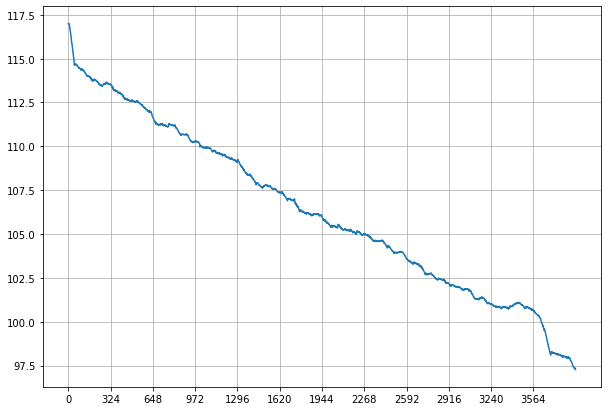

In [ ]:
results, pairs_summary = trader.summarize_results(sharpe_results_threshold_train_w_costs,
                                                  cum_returns_threshold_train_w_costs,
                                                  performance_threshold_train,
                                                  pairs, ticker_segment_dict,
                                                  n_years_val)

Sharpe Ratio Distribution: 


ValueError: supplied range of [-inf, inf] is not finite

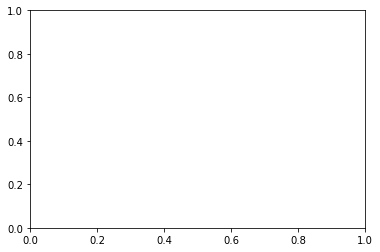

In [ ]:
print('Sharpe Ratio Distribution: ')
n, bins, patches = plt.hist(sharpe_results_threshold_train_w_costs, bins = 16, normed=True, orientation='vertical',
                            color='red', rwidth=0.9, align='mid')

In [ ]:
#cum_returns_threshold_train_w_costs

In [ ]:
betas = list()
for i in range(len(pairs)):
    betas.append(pairs[i][2]['coint_coef'])
np.asarray(betas)

array([ 9.69709007,  3.99019057, 11.72360476,  1.16587638,  0.03224599,
        0.26881034,  0.06864336,  0.89981611,  0.22387887,  0.54415981,
        0.28832675,  0.16357464,  0.77769166,  1.98946836,  2.30713096,
        1.0567911 ,  0.58886023,  1.62117377,  1.17374252,  0.24852677,
        0.62641872,  0.3413239 ,  1.68913867,  1.50500368,  0.7754927 ,
        0.51565057,  1.7498439 ,  2.30639702,  0.3889252 ,  0.33175948,
        0.63083065,  0.49124542,  2.40843279,  1.12131608,  1.47848956,
        0.33876599,  0.23621413,  1.33925858,  0.34248907,  1.35880485,
        1.70518797,  1.0168019 ,  0.31907015,  0.34653885,  0.97583014,
        0.35281004,  0.15527104,  0.35825616,  0.59190992,  0.2671852 ,
        0.23862532,  2.20466475,  1.0706715 ,  0.13138301,  1.63498564,
        0.60942638,  1.35905789,  1.47630462,  0.85720918,  1.34230128,
        0.19185078,  0.473765  ,  0.14374545,  0.14798372,  1.75507662,
        0.70849586,  0.25652017,  0.45850343,  0.21293019,  1.30

# Out of Sample Analysis

In this section, we analyze the performance of the strategy in the validation dataset. 

We proceed with some data exploration analysis. For this purpose we will do the following:

- Analyze which percentage of the identified pairs are still cointegrated in the validation period.
- Analyze which percentage of pairs have positive returns, and how many of those are still cointegrated.
- Analyze how many new pais were not identified to be cointegrated up to the validation period.
- Run strategy for identified pairs in training period.

This analysis will help us getting some insight into how the cointegrated pairs vary from time to time, and therefore how we should allocate our resources to predict when pairs are not cointegrated anymore.

## Applying the Strategy out-of Sample

We might want to apply the strategy in all pairs identified. Or, instead, we might prefer to apply the strategy only on those pairs that turned out to be profitable. Let's compare how both approaches work:

In [ ]:
# intraday
n_years_test = round(len(df_prices_test)/(240*78))

# interday
#n_years_test = round(len(df_prices_test)/(240))

n_years_test

0

### Approach 1: Unrestricted

**Basic Threshold Strategy**

In [ ]:
results_without_costs, results_with_costs, performance_threshold_test = \
                            trader.apply_trading_strategy(pairs, 
                                                           'fixed_beta',
                                                            2,#entry_multiplier,
                                                            0,#exit_multiplier,
                                                            test_mode=True,
                                                            train_val_split=train_val_split
                                                           )
sharpe_results_threshold_test_nocosts, cum_returns_threshold_test_nocosts = results_without_costs
sharpe_results_threshold_test_w_costs, cum_returns_threshold_test_w_costs = results_with_costs

 entry delay turned on.
Pair: 2/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 3/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 4/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 5/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 6/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 7/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 8/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 9/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 10/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 11/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 12/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 13/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 14/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 15/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 16/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 17/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 18/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 19/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 20/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 21/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 22/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 23/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 24/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 25/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 26/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 27/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 28/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 29/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 30/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 31/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 32/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 33/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 35/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 38/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 39/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 40/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 41/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 42/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 43/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 44/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 45/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 46/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 47/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 48/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 49/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 50/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 51/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 52/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 53/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 54/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 55/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 56/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 57/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 58/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 59/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 60/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 61/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 62/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 63/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 64/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 65/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 66/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 67/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 68/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 70/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 71/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 72/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 73/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 74/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 75/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 76/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 77/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 78/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 79/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 80/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 81/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 82/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 83/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 85/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 86/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 87/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 88/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 89/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 90/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 91/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 92/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 93/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 94/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 95/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 96/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 97/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 98/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 99/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 100/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 101/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 102/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 103/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 104/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 105/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 106/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 107/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 108/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 109/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 110/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 111/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 112/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 113/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 114/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 115/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 116/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 117/117

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))
c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Annual ROI:  -14.984463310138363
8.547008547008547 % of the pairs had positive returns
Sharpe Ratio assumming IID returns:  -4.09651489774329
Autocorrelation:  0.02663091563863006
Daily Sharpe Ratio -0.546702018365529
Total number of trades:  11156
Positive trades:  4422
Negative trades:  6734
Total Drawdown Days: 78 days


ValueError: The number of FixedLocator locations (12), usually from a call to set_ticks, does not match the number of ticklabels (6).

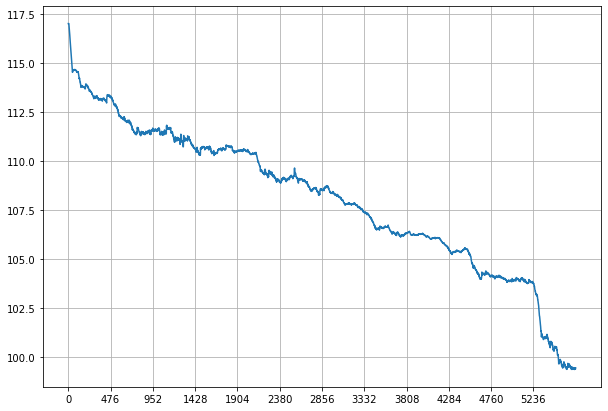

In [ ]:
results, pairs_summary = trader.summarize_results(sharpe_results_threshold_test_w_costs,
                                                  cum_returns_threshold_test_w_costs,
                                                  performance_threshold_test,
                                                  pairs, ticker_segment_dict,
                                                  1)

In [ ]:
print('Corrected Annualized SR: {:.2f}'.format(0.28333093095741857*14.31))

Corrected Annualized SR: 4.05


### Approach 2: Keeping only pairs that had positive returns in the training period

In [ ]:
cum_returns_threshold_train_w_costs = np.asarray(cum_returns_threshold_train_w_costs)
profitable_pairs_indices = np.argwhere(cum_returns_threshold_train_w_costs > 0)
profitable_pairs = [pairs[i] for i in profitable_pairs_indices.flatten()]

In [ ]:
results_without_costs, results_with_costs, performance_threshold_test = \
                            trader.apply_trading_strategy(profitable_pairs, 
                                                           'fixed_beta',
                                                            2,#entry_multiplier,
                                                            0,#exit_multiplier,
                                                            test_mode=True,
                                                            train_val_split=train_val_split
                                                           )
sharpe_results_threshold_test_nocosts, cum_returns_threshold_test_nocosts = results_without_costs
sharpe_results_threshold_test_w_costs, cum_returns_threshold_test_w_costs = results_with_costs

 entry delay turned on.
Pair: 2/9

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 3/9

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 4/9

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 5/9

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 6/9

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 8/9

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 9/9

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))
c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Annual ROI:  -8.745000288571514
22.22222222222222 % of the pairs had positive returns
Sharpe Ratio assumming IID returns:  -1.0760422088616477
Autocorrelation:  -0.049982208684328275
Daily Sharpe Ratio -0.13078859938892076
Total number of trades:  811
Positive trades:  289
Negative trades:  522
Total Drawdown Days: 47 days


ValueError: The number of FixedLocator locations (12), usually from a call to set_ticks, does not match the number of ticklabels (6).

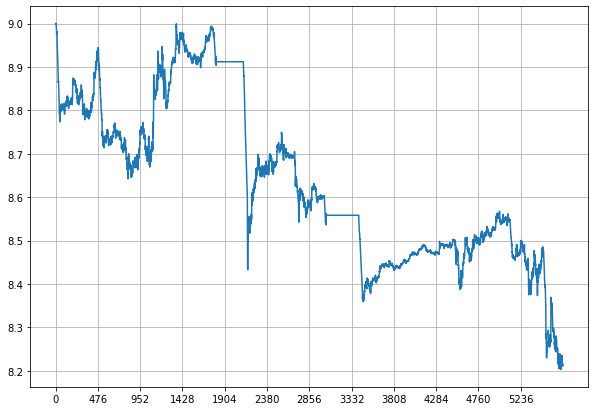

In [ ]:
results, pairs_summary = trader.summarize_results(sharpe_results_threshold_test_w_costs,
                                                  cum_returns_threshold_test_w_costs,
                                                  performance_threshold_test,
                                                  profitable_pairs, ticker_segment_dict,
                                                  1)

### Approach 3: Keeping only top 10 pairs

In [ ]:
sharpe_results_threshold_train_w_costs = np.asarray(sharpe_results_threshold_train_w_costs)
sorted_pairs_indices = np.argsort(sharpe_results_threshold_train_w_costs)[::-1][:10]
top_10_pairs = [pairs[i] for i in sorted_pairs_indices.flatten()]

In [ ]:
# sorting by returns seems to give better results

In [ ]:
cum_returns_threshold_train_w_costs = np.asarray(cum_returns_threshold_train_w_costs)
sorted_pairs_indices = np.argsort(cum_returns_threshold_train_w_costs)[::-1][:10]
top_10_pairs = [pairs[i] for i in sorted_pairs_indices.flatten()]

In [ ]:
results_without_costs, results_with_costs, performance_threshold_test = \
                            trader.apply_trading_strategy(top_10_pairs, 
                                                           'fixed_beta',
                                                            2,#entry_multiplier,
                                                            0,#exit_multiplier,
                                                            test_mode=True,
                                                            train_val_split=train_val_split
                                                           )
sharpe_results_threshold_test_nocosts, cum_returns_threshold_test_nocosts = results_without_costs
sharpe_results_threshold_test_w_costs, cum_returns_threshold_test_w_costs = results_with_costs

 entry delay turned on.
Pair: 2/10

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 3/10

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 4/10

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 5/10

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 6/10

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 7/10

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 9/10

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Pair: 10/10

c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))
c:\PairsTrading\class_Trader.py:462: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ratio = (annualized_ret-rf[year]) / (np.std(daily_ret)*np.sqrt(time_in_market))


Annual ROI:  -9.04446133365755
20.0 % of the pairs had positive returns
Sharpe Ratio assumming IID returns:  -1.116689597120966
Autocorrelation:  0.035847854462024424
Daily Sharpe Ratio -0.136572380683521
Total number of trades:  939
Positive trades:  321
Negative trades:  618
Total Drawdown Days: 49 days


ValueError: The number of FixedLocator locations (12), usually from a call to set_ticks, does not match the number of ticklabels (6).

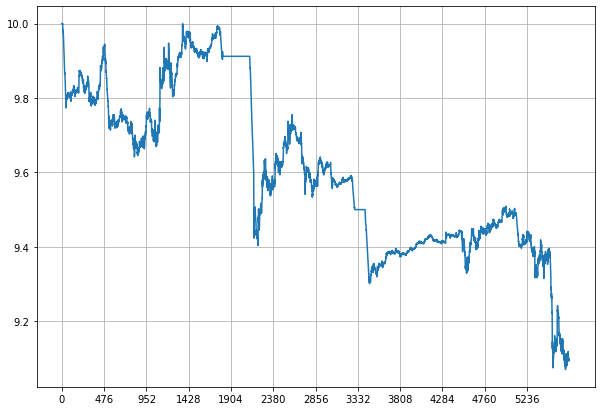

In [ ]:
results, pairs_summary = trader.summarize_results(sharpe_results_threshold_test_w_costs,
                                                  cum_returns_threshold_test_w_costs,
                                                  performance_threshold_test,
                                                  top_10_pairs, ticker_segment_dict,
                                                  1)